In [58]:
import math
import random
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.utils.class_weight
from sklearn import svm,tree
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import seaborn as sns


In [59]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Prepare the dataset


In [118]:
dataset=pd.read_csv("train_set.tsv",sep='\t',header=0)

#print(dataset["num_collisions"].value_counts(normalize=False))

X=dataset.iloc[:,:-2]  # : all raws :-2 slice out the last 2 columns
y=dataset.iloc[:,-2]   #just the last column

#normalized_df=(dataset-dataset.mean())/dataset.std()
Stdscaler = preprocessing.StandardScaler().fit(X)
X= Stdscaler.transform(X)
#X=(X-X.min())/(X.max()-X.min())  #between 0 and 1 (is column-wise)
#print(X.describe)
#print(X.std())
random_state=12
d={
   2:80,
   3:40,
   4:30
}
smote=SMOTE(sampling_strategy=d,k_neighbors=1)
#smote=SMOTEENN(smote=smote)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=random_state) #to be reproducible
X_train,y_train=smote.fit_resample(X_train,y_train)
print("train-set composition: ",y_train.value_counts(normalize=False))
print("test-set composition: ",y_test.value_counts(normalize=False))



print("Number of training samples: %d" %(X_train.shape[0]))
print("Number of test samples: %d" %(X_test.shape[0]))


train-set composition:  0    413
1    241
2     80
3     40
4     30
Name: num_collisions, dtype: int64
test-set composition:  0    125
1     92
2     25
3      7
4      1
Name: num_collisions, dtype: int64
Number of training samples: 804
Number of test samples: 250


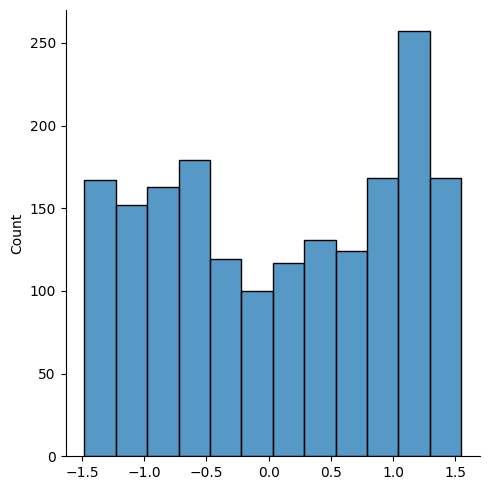

In [149]:
sns.displot(X[:,4])

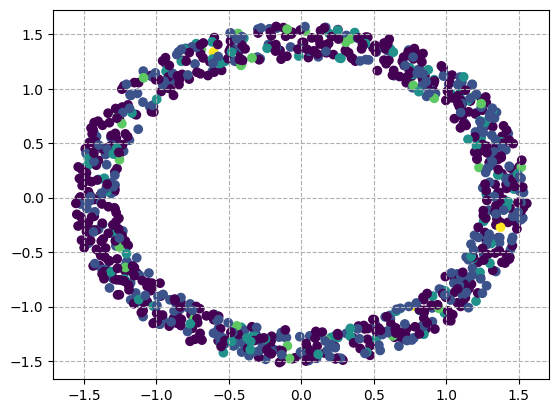

In [28]:
# select the first two features
X_reduced = X[:,3:5]
#no lineary separable in 2D with only 2 features

plt.figure()
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.grid(linestyle="--")

GaussianNB

Input shape reduced train: (427, 2)
Input shape reduced test: (183, 2)


Text(0.5, 1.0, 'Training and test samples')

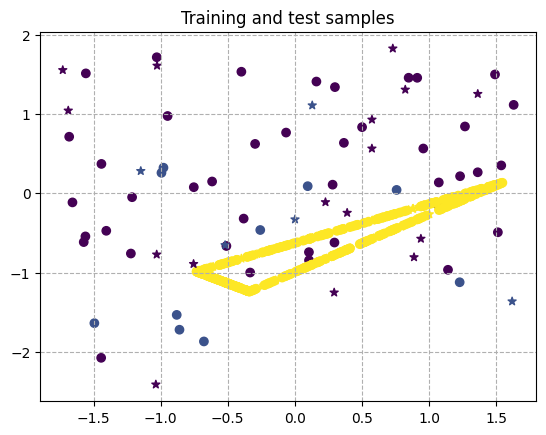

In [162]:
# select the first two features
X_train_reduced = X_train[:,0:2]
X_test_reduced = X_test[:,0:2]
print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print("Input shape reduced test: %s" %str(X_test_reduced.shape))

plt.figure()
plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=y_train)
plt.scatter(X_test_reduced[:,0], X_test_reduced[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Training and test samples")

In [163]:
gen_model = GaussianNB()
gen_model.fit(X_train_reduced, y_train)
y_pred = gen_model.predict(X_test_reduced)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)


Accuracy 0.929


Accuracy 0.492
[0.65768194 0.02083333 0.         0.         0.        ]


[Text(0.5, 0.875, 'X[18] <= -1.365\ngini = 0.633\nsamples = 804\nvalue = [413, 241, 80, 40, 30]'),
 Text(0.25, 0.625, 'X[18] <= -1.367\ngini = 0.681\nsamples = 75\nvalue = [27, 12, 4, 2, 30]'),
 Text(0.125, 0.375, 'X[21] <= -0.648\ngini = 0.566\nsamples = 44\nvalue = [26, 12, 4, 2, 0]'),
 Text(0.0625, 0.125, 'gini = 0.622\nsamples = 15\nvalue = [4, 8, 2, 1, 0]'),
 Text(0.1875, 0.125, 'gini = 0.4\nsamples = 29\nvalue = [22, 4, 2, 1, 0]'),
 Text(0.375, 0.375, 'X[22] <= -0.145\ngini = 0.062\nsamples = 31\nvalue = [1, 0, 0, 0, 30]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0, 0]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 30\nvalue = [0, 0, 0, 0, 30]'),
 Text(0.75, 0.625, 'X[5] <= -0.473\ngini = 0.607\nsamples = 729\nvalue = [386, 229, 76, 38, 0]'),
 Text(0.625, 0.375, 'X[8] <= 0.059\ngini = 0.547\nsamples = 272\nvalue = [168, 68, 20, 16, 0]'),
 Text(0.5625, 0.125, 'gini = 0.599\nsamples = 148\nvalue = [79, 48, 13, 8, 0]'),
 Text(0.6875, 0.125, 'gini = 0.451\nsa

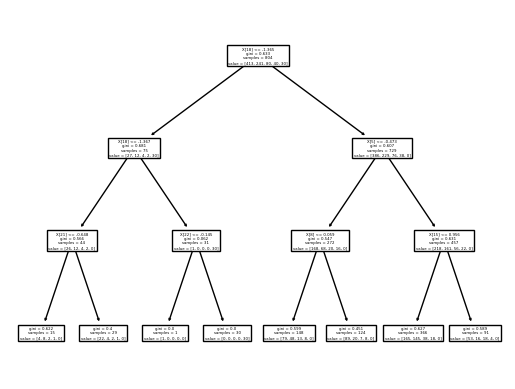

In [121]:
classifier=DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
tree.plot_tree(classifier)


Accuracy 0.524
[0.65562914 0.4        0.         0.16666667 0.        ]
              precision    recall  f1-score   support

           0       0.56      0.79      0.66       125
           1       0.49      0.34      0.40        92
           2       0.00      0.00      0.00        25
           3       0.20      0.14      0.17         7
           4       0.00      0.00      0.00         1

    accuracy                           0.52       250
   macro avg       0.25      0.25      0.24       250
weighted avg       0.47      0.52      0.48       250



/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


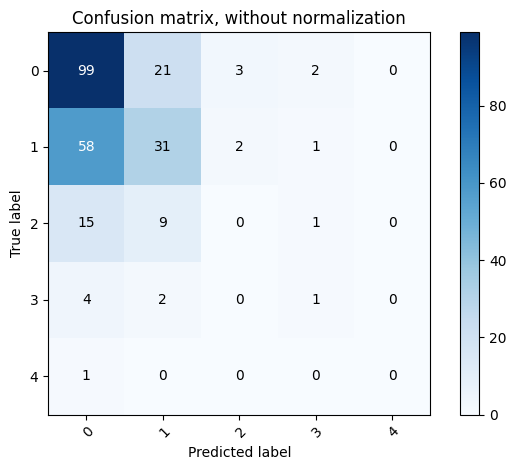

In [122]:
#classifier=svm.SVC(C=0.9,kernel='rbf',gamma='scale',class_weight='balanced')
classifier=svm.SVC(C=1.0,kernel='poly',degree=4,gamma='scale',class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]))
print(classification_report(y_test, y_pred))


Ensemble of kernelized methods and simple methods with BOOSTING (trying to improve Aaccuracy)


In [76]:
classifier_name = 'D'
algorithm = 'SAMME' 
n_estimators=np.random.randint(5, 70, 5)

all_classifiers = {
    'G': [GaussianNB, 'Gaussian Naive Bayes'],
    'P': [Perceptron(), 'Perceptron'],
    'LR': [LogisticRegression, 'Logistic Regression'],
    'D': [DecisionTreeClassifier, 'Decision Tree'],
    'S': [svm.SVC, 'SVM']     
    }

#print(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=y))

boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': n_estimators,
  }

Accuracy on train_set: 0.513 Accuracy on test_set: 0.500
f1-score:  [0.66666667 0.         0.         0.         0.        ]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       125
           1       0.00      0.00      0.00        92
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         1

    accuracy                           0.50       250
   macro avg       0.10      0.20      0.13       250
weighted avg       0.25      0.50      0.33       250



/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

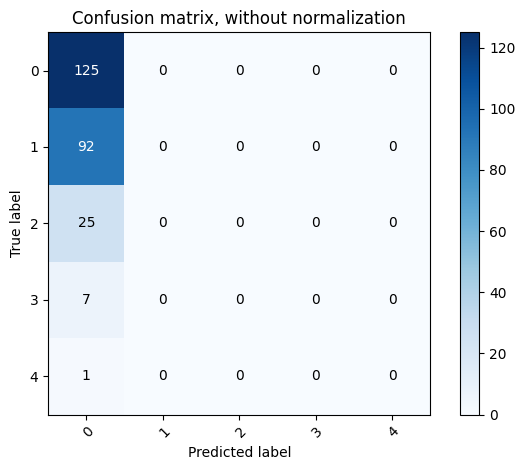

In [110]:

adaboost_classifier = AdaBoostClassifier(
    base_estimator=all_classifiers['S'][0](C=1.0,kernel='poly',degree=4,gamma='scale'),    
    n_estimators=44, 
    learning_rate=0.08, 
    algorithm= algorithm, 
    random_state=random_state
    ).fit(X_train, y_train)

y_pred=adaboost_classifier.predict(X_test)
ada_accuracy_train = adaboost_classifier.score(X_train, y_train)  
ada_accuracy_test = adaboost_classifier.score(X_test,y_test)
print("Accuracy on train_set: %.3f" %ada_accuracy_train,"Accuracy on test_set: %.3f" %ada_accuracy_test)
print("f1-score: ",sklearn.metrics.f1_score(y_test, y_pred,average=None))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]))

In [79]:
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
#print(sklearn.metrics.get_scorer_names())
grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='accuracy',   #accuracy,f1_micro,f1_macro,balanced_accuracy,f1_weighted
    cv=cv, 
    return_train_score=False,
    verbose=0,
    
)
grid_search_boosting.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for boosting classifier: %r" %grid_search_boosting.best_params_)
print("Best accuracy: %.4f" %grid_search_boosting.best_score_)
print("Boosting Accuracy over the test set: %.4f" %grid_search_boosting.score(X_test, y_test))

Best classification hyper-parameters for boosting classifier: {'learning_rate': 0.08371396890623406, 'n_estimators': 44}
Best accuracy: 0.4968
Boosting Accuracy over the test set: 0.5233


Bagging

Accuracy on train_set: 0.605 Accuracy on test_set: 0.508
[0.67027027 0.06185567 0.         0.         0.        ]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

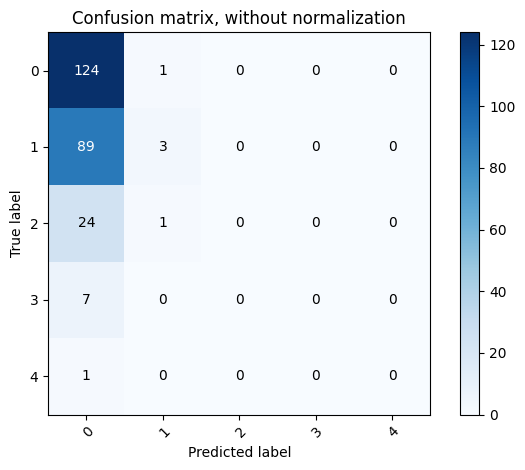

In [111]:
bagging_params = {
  'max_samples': np.random.randint(5,int(len(X_train)/2), 5),
  'n_estimators': n_estimators,
}
bagging_classifier = BaggingClassifier(
    base_estimator=all_classifiers[classifier_name][0](max_depth=4), 
    max_samples=276, 
    n_estimators=44,  
    random_state=random_state,
    ).fit(X_train, y_train)

y_pred=bagging_classifier.predict(X_test)
bagging_accuracy_test = bagging_classifier.score(X_test, y_test)
bagging_accuracy_train = bagging_classifier.score(X_train, y_train)  
print("Accuracy on train_set: %.3f" %bagging_accuracy_train,"Accuracy on test_set: %.3f" %bagging_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]))



In [82]:
grid_search_bagging = GridSearchCV(
    bagging_classifier,
    bagging_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    # change max_features
    verbose=0
)
grid_search_bagging.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for bagging classifier: %r" %grid_search_bagging.best_params_)
print("Best accuracy: %.4f" %grid_search_bagging.best_score_)
print("Bagging Accuracy over the test set: %.4f" %grid_search_bagging.score(X_test, y_test))

Best classification hyper-parameters for bagging classifier: {'max_samples': 276, 'n_estimators': 44}
Best accuracy: 0.5359
Bagging Accuracy over the test set: 0.5233
